In [1]:
import numpy as np
import pandas as pd
from calendar import monthrange
from typing import Union, List, Dict
from libraries.IndexesExtraction import IndexesExtraction

In [3]:
periods = [str(i) for i in list(range(1964, 2022))]

In [2]:
classification_rules = {
    'fraca':            np.array(range(-31, -51, -1)),
    'moderada':         np.array(range(-51, -101, -1)),
    'intensa':          np.array(range(-101, -251, -1)),
    'super_intensa':    np.array(range(-251, -1001, -1)),
}

# indexes = IndexesExtraction(periods=periods)
# indexes.make_classification(classification_rules, classification_by_column='Dst_index')

In [4]:
#/home/gabriel/tcc/OMNI/processed_data/{name}.h5
#F:/Meus_Documentos/Documentos/GitHub/analysis-of-magnetic-storms/OMNI/processed_data/full_data.h5

In [3]:
def save_processed_data(df, folder_name: str, name: str):
    processed_data = pd.HDFStore(path=f'F:/Meus_Documentos/Documentos/GitHub/analysis-of-magnetic-storms/OMNI/processed_data/full_data.h5')
    processed_data.append('df', df)
    processed_data.close()
    print(f'Seus dados foram salvos em: processed_data/{name}.h5\n')


 #save_processed_data(df=df_test, folder_name='OMNI', name='full_data')

def load_processed_data(folder_name:str, name: str):
    processed_data = pd.HDFStore(path=f'/home/gabriel/tcc/OMNI/processed_data/full_data.h5')
    df = processed_data['df']
    processed_data.close()
    return df


In [4]:

data = load_processed_data(folder_name='OMNI', name='full_data')

In [5]:
df_test = data.copy()

In [27]:
df_test

,date,Dst_index,Kp_index,B_scalar,Bz_GSM,classification
6,2001-06-07,-36.0,57.0,12.5,-6.1,fraca
11,2001-06-12,-61.0,53.0,19.3,-11.8,moderada
17,2001-06-18,-33.0,57.0,8.4,-4.1,fraca
26,2001-06-27,-46.0,37.0,16.3,-7.1,fraca
41,1986-12-12,-39.0,43.0,999.9,999.9,fraca
...,...,...,...,...,...,...
21176,1996-09-22,-37.0,27.0,7.5,-3.2,fraca
21177,1996-09-23,-42.0,50.0,12.2,-7.5,fraca
21180,1996-09-26,-38.0,50.0,9.3,-5.7,fraca
21183,1996-09-29,-42.0,43.0,9.7,-4.8,fraca


In [6]:
df_test.drop(df_test[df_test['Dst_index'] == 999.9].index, inplace=True)
df_test.drop(df_test[df_test['B_scalar'] == 999.9].index, inplace=True)
df_test.drop(df_test[df_test['Bz_GSM'] == 999.9].index, inplace=True)
df_test.drop(df_test[df_test['Dst_index'] == 999.9].index, inplace=True)

In [7]:
def class_count(df):
    count = {"fraca": 0, "moderada": 0, "intensa": 0, "super_intensa": 0}
    for i in range(1, len(df)):
        count[df['classification'].iloc[i]]+=1
    print(count)

In [30]:
class_count(df_test)

{'fraca': 2241, 'moderada': 1105, 'intensa': 216, 'super_intensa': 15}


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [38]:
def plot_confusion_matrix(matrix_data, le: LabelEncoder):  
    fig, ax = plt.subplots()
    sns.heatmap(
        matrix_data, 
        annot=True, 
        ax=ax, 
        fmt='d', 
        cmap='Reds',
        cbar=False,
        # xticklabels=le.classes_,
        # yticklabels=le.classes_
        xticklabels=["fraca", "intensa", "moderada", "super_intensa"],
        yticklabels=["fraca", "intensa", "moderada", "super_intensa"]
    )

    ax.set_title("Matriz de Confusão", fontsize=16)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    plt.tight_layout()

In [9]:
def model_evaluation(y_train, y_test, y_pred, partition: str):
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)

    if partition == 'tr':
        print("\nRelatório de Classificação do modelo final:\n\n", classification_report(y_train, y_pred, digits=4))
        matrix = confusion_matrix(y_train, y_pred)

    if partition == 'te':
        print("\nRelatório de Classificação do modelo final:\n\n", classification_report(y_test, y_pred, digits=4))
        matrix = confusion_matrix(y_test, y_pred)
        

    #Matriz de confusão
    fig, ax = plt.subplots()
    sns.heatmap(matrix, annot=True, ax=ax, fmt='d', cmap='Reds')

    ax.set_title("Matriz de Confusão", fontsize=18)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted Label")

    plt.tight_layout()

In [10]:
def accuracy_range(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
    print(results)
    print('--------------------------------------------------------------')

In [11]:
def precision_range(results):
  mean = results.mean()
  dv = results.std()
  print('Precisão média: {:.2f}%'.format(mean*100))
  print('Intervalo de precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
  print(results)
  print('--------------------------------------------------------------')

In [12]:
def recall_range(results):
  mean = results.mean()
  dv = results.std()
  print('Recall médio: {:.2f}%'.format(mean*100))
  print('Intervalo de recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
  print(results)
  print('--------------------------------------------------------------')

In [13]:
import sklearn.base, sklearn.model_selection
def cros_val_scoring(model: sklearn.base.BaseEstimator, x: any, y:any, cv):
    accuracy = cross_val_score(model, x, y, cv = cv, scoring='accuracy')
    precision = cross_val_score(model, x, y, cv = cv, scoring='precision_macro')
    recall = cross_val_score(model, x, y, cv = cv, scoring='recall_macro')

    accuracy_range(accuracy)
    precision_range(precision)
    recall_range(recall)

In [15]:
#MODELO BZ -> Dst class

def bz_model():

    #Codificação da classe alvo
    le = LabelEncoder()
    df_test['classification'] = le.fit_transform(df_test['classification'])

    X = df_test['B_scalar'].values.reshape(-1, 1) 
    y = df_test['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [16]:
#MODELO DST-MIN_BZ -> Dst class

def dstMin_bz_model():

    #Codificação da classe alvo
    le = LabelEncoder()
    df_test['classification'] = le.fit_transform(df_test['classification'])

    X = df_test[['Dst_index','B_scalar']].copy()
    y = df_test['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [17]:
#MODELO DST-MIN_KP-MAX_BZ -> Dst class

def dstMin_kpMax_bz_model():

    #Codificação da classe alvo
    le = LabelEncoder()
    df_test['classification'] = le.fit_transform(df_test['classification'])

    X = df_test[['Dst_index','Kp_index','B_scalar']].copy()
    y = df_test['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [53]:
#MODELO DST-MIN -> Dst class
import numpy as np
def dstMin_model():
    #Codificação da classe alvo
    le = LabelEncoder()
    df_test['classification'] = le.fit_transform(df_test['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = df_test['Dst_index'].values.reshape(-1, 1) 
    y = df_test['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(matrix, le)

    report = classification_report(y_true=y_test, y_pred=y_pred)
    print(report)

    # indetificar outliers
    df_test.filter(items=(y_test != y_pred).index[np.where(y_test != y_pred)[0]], axis=0)
    # model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [19]:
#MODELO KP -> Dst class
def kp_model():
    #Codificação da classe alvo
    le = LabelEncoder()
    df_test['classification'] = le.fit_transform(df_test['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = df_test['Kp_index'].values.reshape(-1, 1) 
    y = df_test['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [20]:
#MODELO DST-MIN_KP -> Dst class
def dstMin_kp_model():
    #Codificação da classe alvo
    le = LabelEncoder()
    df_test['classification'] = le.fit_transform(df_test['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = df_test[['Dst_index','Kp_index']].copy()
    y = df_test['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

O dataset de treino possui 2504 tempestades e o de teste 1074 tempestades.
--------------------------------------------------------------
Acurácia média: 99.40%
Intervalo de acurácia: [98.84% ~ 99.97%]
[0.99800399 0.99001996 0.99600798 0.99401198 0.992     ]
--------------------------------------------------------------
Precisão média: 93.85%
Intervalo de precisão: [83.44% ~ 104.26%]
[0.85080645 0.90833333 0.9921875  0.97058824 0.97058824]
--------------------------------------------------------------
Recall médio: 99.14%
Intervalo de recall: [97.86% ~ 100.43%]
[0.99516129 0.98844086 0.99675325 0.99675325 0.98010753]
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       673
           1       0.96      1.00      0.98        65
           2       1.00      0.99      1.00       332
           3       1.00      1.00      1.00         4

    accuracy                           1

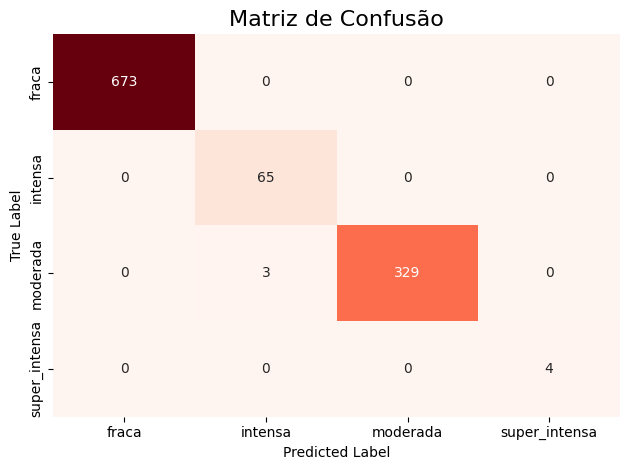

In [54]:
dstMin_model()
#bz_model()
#kp_model()
#dstMin_bz_model()
#dstMin_kp_model()
# dstMin_kpMax_bz_model()